In [1]:
# Setup
import sys
import json
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, HTML

# Derive project root similar to explore_data notebook
notebook_dir = Path.cwd()
if notebook_dir.name == "notebooks":
    project_root = notebook_dir.parent
else:
    project_root = notebook_dir
    while project_root.parent != project_root:
        if (project_root / "pyproject.toml").exists():
            break
        project_root = project_root.parent

sys.path.insert(0, str(project_root))

# Display settings
pd.set_option('display.max_colwidth', 100)
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams['figure.figsize'] = (10, 5)

display(Markdown("## ✅ Explore Prompts Notebook Ready"))
display(Markdown(f"**Project root:** `{project_root}`"))

## ✅ Explore Prompts Notebook Ready

**Project root:** `c:\Users\ammah\Documents\GitHub\fred-llm`

## 1. Discover Available Prompt Files

In [2]:
# Find all generated prompt files
prompts_dir = project_root / "data" / "prompts"

all_jsonl_files = []
file_info = []

if prompts_dir.exists():
    for subdir in sorted(prompts_dir.iterdir()):
        if subdir.is_dir():
            jsonl_files = list(subdir.glob("*.jsonl"))
            for f in jsonl_files:
                size_kb = f.stat().st_size / 1024
                all_jsonl_files.append(f)
                file_info.append({
                    "Directory": subdir.name,
                    "File": f.name,
                    "Size (KB)": f"{size_kb:.1f}"
                })

if file_info:
    display(Markdown("### 📁 Available Prompt Files"))
    display(pd.DataFrame(file_info).style.set_properties(**{'text-align': 'left'}))
    display(Markdown(f"**Total:** {len(all_jsonl_files)} prompt files found"))
else:
    display(Markdown("⚠️ **No prompt files found.** Run prompt generation first:\n```bash\nuv run python -m src.cli prompt generate data/processed/training_data/train.csv\n```"))

### 📁 Available Prompt Files

,Directory,File,Size (KB)
0,basic,test_infix_basic.jsonl,1059.1
1,chain-of-thought,test_infix_chain-of-thought.jsonl,1462.5
2,demo,test_rpn_few-shot.jsonl,2062.7
3,test,test_infix_basic.jsonl,1059.1
4,test,test_latex_basic.jsonl,1149.5


**Total:** 5 prompt files found

## 2. Load Prompts into DataFrame

In [3]:
def load_jsonl(file_path: Path) -> list[dict]:
    """Load a JSONL file."""
    with open(file_path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f if line.strip()]

# Load all prompts into a combined DataFrame
all_prompts = []
for jsonl_file in all_jsonl_files:
    prompts = load_jsonl(jsonl_file)
    for p in prompts:
        p["source_file"] = jsonl_file.name
        p["source_dir"] = jsonl_file.parent.name
    all_prompts.extend(prompts)

df = pd.DataFrame(all_prompts)

display(Markdown(f"### 📊 Loaded {len(df):,} prompts"))
if len(df) > 0:
    display(Markdown(f"**Columns:** `{', '.join(df.columns)}`"))
    display(Markdown(f"**Shape:** {df.shape[0]} rows × {df.shape[1]} columns"))

### 📊 Loaded 5,595 prompts

**Columns:** `equation_id, prompt, style, format_type, ground_truth, metadata, source_file, source_dir`

**Shape:** 5595 rows × 8 columns

In [4]:
# Add derived columns (only if we have data)
if len(df) > 0:
    df["prompt_length"] = df["prompt"].str.len()
    df["prompt_lines"] = df["prompt"].str.count("\n") + 1
    df["has_ground_truth"] = df["ground_truth"].notna()

    # Extract metadata fields
    if "metadata" in df.columns:
        df["kernel"] = df["metadata"].apply(lambda x: x.get("kernel", "") if isinstance(x, dict) else "")
        df["f_function"] = df["metadata"].apply(lambda x: x.get("f", "") if isinstance(x, dict) else "")
        df["lambda_val"] = df["metadata"].apply(lambda x: x.get("lambda_val", 0) if isinstance(x, dict) else 0)

    display(Markdown("### 📋 Sample Data"))
    display(df.head())
else:
    display(Markdown("*No data to display*"))

### 📋 Sample Data

,equation_id,prompt,style,format_type,ground_truth,metadata,source_file,source_dir,prompt_length,prompt_lines,has_ground_truth,kernel,f_function,lambda_val
0,eq_0,You are an expert mathematician specializing in integral equations.\nGiven a Fredholm integral e...,basic,infix,-2.4902968211708076*x**5,"{'kernel': 't**2', 'f': '-2.4902968211708076*x**5 - 94400470.105430238', 'lambda_val': 4.3803921...",test_infix_basic.jsonl,basic,519,15,True,t**2,-2.4902968211708076*x**5 - 94400470.105430238,4.380392
1,eq_1,You are an expert mathematician specializing in integral equations.\nGiven a Fredholm integral e...,basic,infix,x**2,"{'kernel': 'cosh(t - 7.271073299924675)', 'f': 'x**2 - 492855.9937811647', 'lambda_val': 5.76017...",test_infix_basic.jsonl,basic,523,15,True,cosh(t - 7.271073299924675),x**2 - 492855.9937811647,5.760172
2,eq_2,You are an expert mathematician specializing in integral equations.\nGiven a Fredholm integral e...,basic,infix,0.9448577499153583,"{'kernel': '-868.7598313470291*t + x - 868.7598313470291*tan(x) - 3288.900993876633', 'f': '-22....",test_infix_basic.jsonl,basic,613,15,True,-868.7598313470291*t + x - 868.7598313470291*tan(x) - 3288.900993876633,-22.12259317215731*x + 19219.22031320232*tan(x) + 113285.2053606025,9.208239
3,eq_3,You are an expert mathematician specializing in integral equations.\nGiven a Fredholm integral e...,basic,infix,x,"{'kernel': '-t + 8.5724347982155745*x**3/(t*cos(x))', 'f': '1072.6432736501701*x**3/cos(x) + x -...",test_infix_basic.jsonl,basic,566,15,True,-t + 8.5724347982155745*x**3/(t*cos(x)),1072.6432736501701*x**3/cos(x) + x - 2222.51864004133,-8.845667
4,eq_4,You are an expert mathematician specializing in integral equations.\nGiven a Fredholm integral e...,basic,infix,-x**4 - 3.930094625178267,"{'kernel': 'x*cos(t)', 'f': '-x**4 + 890.500161160994*x - 3.930094625178267', 'lambda_val': -2.4...",test_infix_basic.jsonl,basic,527,15,True,x*cos(t),-x**4 + 890.500161160994*x - 3.930094625178267,-2.442341


## 3. Prompt Statistics Overview

In [5]:
if len(df) > 0:
    display(Markdown("### 📊 Distribution Summary"))

    # Create summary tables
    style_counts = df["style"].value_counts().to_frame("Count")
    format_counts = df["format_type"].value_counts().to_frame("Count")
    source_counts = df["source_dir"].value_counts().to_frame("Count")

    # Display side by side using HTML
    html = f"""
    <div style="display: flex; gap: 40px; flex-wrap: wrap;">
        <div>
            <h4>By Style</h4>
            {style_counts.to_html()}
        </div>
        <div>
            <h4>By Format</h4>
            {format_counts.to_html()}
        </div>
        <div>
            <h4>By Source</h4>
            {source_counts.to_html()}
        </div>
    </div>
    """
    display(HTML(html))
else:
    display(Markdown("*No data to display*"))

### 📊 Distribution Summary

,Count
style,
basic,3441
chain-of-thought,1154
few-shot,1000
,Count
format_type,
infix,3462
latex,1133
rpn,1000
,Count


In [6]:
if len(df) > 0:
    display(Markdown("### 📏 Prompt Length Statistics"))

    length_stats = df.groupby("style")["prompt_length"].agg(["min", "max", "mean", "median", "std"])
    length_stats = length_stats.round(0).astype(int)
    length_stats.columns = ["Min", "Max", "Mean", "Median", "Std Dev"]

    display(length_stats.style.background_gradient(cmap="Blues", subset=["Mean", "Median"]))

### 📏 Prompt Length Statistics

,Min,Max,Mean,Median,Std Dev
style,,,,,
basic,465,5190,588,563,151
chain-of-thought,803,3342,914,892,122
few-shot,1514,5172,1638,1606,177


## 4. Visualizations

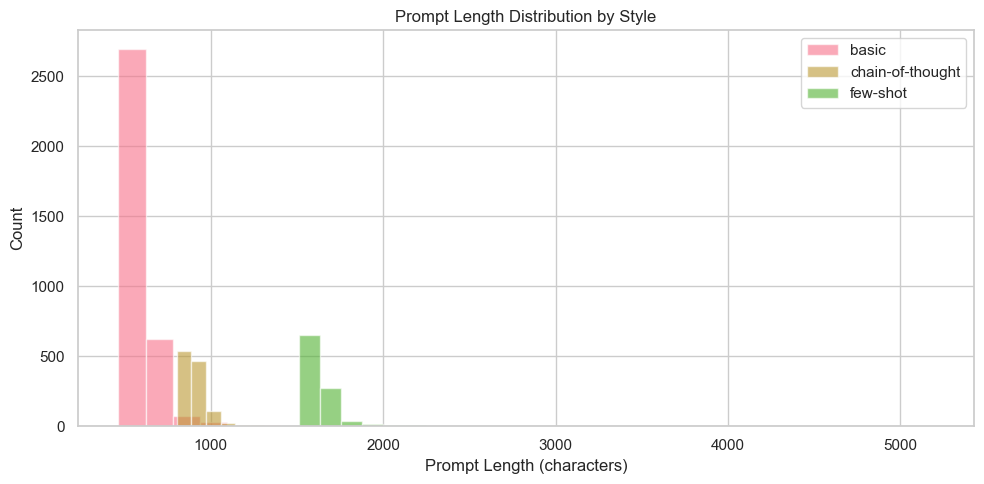

In [7]:
if len(df) > 0:
    # Prompt length distribution by style
    fig, ax = plt.subplots(figsize=(10, 5))

    for style in df["style"].unique():
        subset = df[df["style"] == style]["prompt_length"]
        ax.hist(subset, bins=30, alpha=0.6, label=style)

    ax.set_xlabel("Prompt Length (characters)")
    ax.set_ylabel("Count")
    ax.set_title("Prompt Length Distribution by Style")
    ax.legend()
    plt.tight_layout()
    plt.show()

C:\Users\ammah\AppData\Local\Temp\ipykernel_26368\607594714.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="style", y="prompt_length", palette="husl", ax=ax)


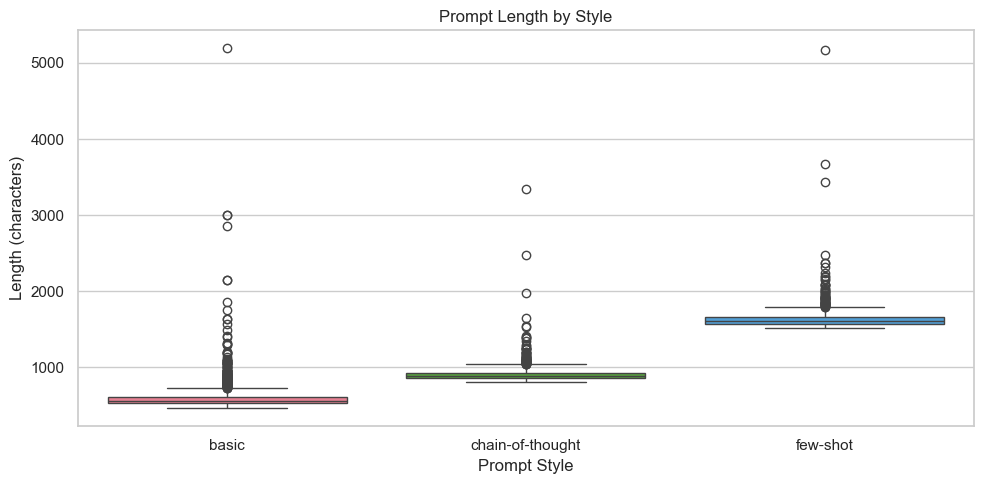

In [8]:
if len(df) > 0:
    # Box plot of prompt lengths by style
    fig, ax = plt.subplots(figsize=(10, 5))

    sns.boxplot(data=df, x="style", y="prompt_length", palette="husl", ax=ax)
    ax.set_xlabel("Prompt Style")
    ax.set_ylabel("Length (characters)")
    ax.set_title("Prompt Length by Style")
    plt.tight_layout()
    plt.show()

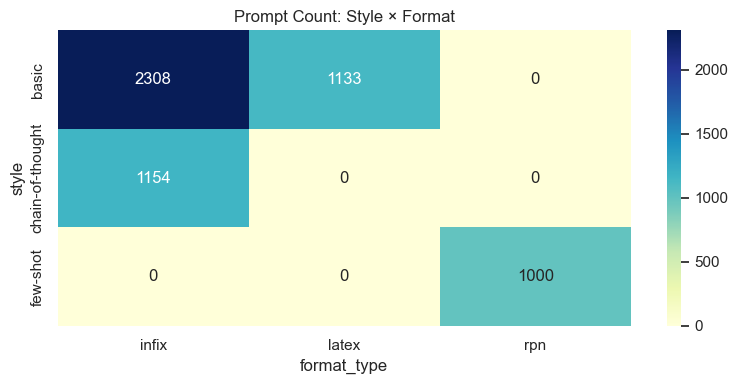

In [9]:
if len(df) > 0 and df["format_type"].nunique() > 1:
    # Style and format heatmap
    pivot = df.pivot_table(
        index="style", 
        columns="format_type", 
        values="equation_id", 
        aggfunc="count",
        fill_value=0
    )
    
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.heatmap(pivot, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
    ax.set_title("Prompt Count: Style × Format")
    plt.tight_layout()
    plt.show()
elif len(df) > 0:
    display(Markdown(f"ℹ️ Only one format type found: **{df['format_type'].iloc[0]}**"))

## 5. Sample Prompt Inspection

In [10]:
def display_prompt_card(row, max_length=2000):
    """Display a prompt as a styled card."""
    gt_html = f"<p><strong>Ground Truth:</strong> <code>{row['ground_truth']}</code></p>" if row.get('ground_truth') else ""
    
    prompt = row['prompt']
    if len(prompt) > max_length:
        prompt = prompt[:max_length] + f"\n\n... [truncated, {len(prompt) - max_length} more chars]"
    
    html = f"""
    <div style="border: 1px solid #ddd; border-radius: 8px; padding: 16px; margin: 12px 0; background: #f9f9f9;">
        <div style="display: flex; justify-content: space-between; margin-bottom: 8px;">
            <span style="font-weight: bold; color: #333;">📝 {row['equation_id']}</span>
            <span style="color: #666;">
                <span style="background: #e3f2fd; padding: 2px 8px; border-radius: 4px; margin-right: 8px;">{row['style']}</span>
                <span style="background: #f3e5f5; padding: 2px 8px; border-radius: 4px;">{row['format_type']}</span>
            </span>
        </div>
        <p style="color: #666; font-size: 0.9em;">Length: {row['prompt_length']:,} chars | Lines: {row['prompt_lines']}</p>
        {gt_html}
        <pre style="background: #fff; padding: 12px; border-radius: 4px; overflow-x: auto; font-size: 0.85em; white-space: pre-wrap;">{prompt}</pre>
    </div>
    """
    display(HTML(html))

if len(df) > 0:
    # Show one sample from each style
    display(Markdown("### 🔍 Sample Prompts by Style"))
    for style in df["style"].unique():
        sample = df[df["style"] == style].iloc[0]
        display_prompt_card(sample, max_length=1500)

### 🔍 Sample Prompts by Style

## 6. Ground Truth Analysis

In [11]:
if len(df) > 0 and "ground_truth" in df.columns:
    display(Markdown("### 🎯 Ground Truth Analysis"))
    
    gt_present = df["has_ground_truth"].sum()
    pct = gt_present / len(df) * 100
    
    display(Markdown(f"**Prompts with ground truth:** {gt_present:,} / {len(df):,} ({pct:.1f}%)"))
    
    # Solution complexity (by length)
    df["gt_length"] = df["ground_truth"].fillna("").str.len()
    
    gt_stats = df[df["has_ground_truth"]]["gt_length"].describe().to_frame("Value")
    gt_stats = gt_stats.round(1)
    
    display(Markdown("#### Ground Truth Length Statistics"))
    display(gt_stats)
    
    # Sample ground truths
    if gt_present > 0:
        display(Markdown("#### Sample Solutions"))
        samples = df[df["has_ground_truth"]]["ground_truth"].sample(min(10, gt_present)).tolist()
        for i, gt in enumerate(samples, 1):
            display(Markdown(f"{i}. `{gt}`"))

### 🎯 Ground Truth Analysis

**Prompts with ground truth:** 5,595 / 5,595 (100.0%)

#### Ground Truth Length Statistics

,Value
count,5595.0
mean,21.7
std,23.9
min,1.0
25%,4.0
50%,17.0
75%,27.0
max,162.0


#### Sample Solutions

1. `x^{5} - 2.752480171400956 x^{3} - x - \cosh{\left(x \right)}`

2. `-9.104378910327899`

3. `x**4`

4. `-3.0287623316320863 1.862717231384444 x 2 ^ * + 1 x * x exp * neg +`

5. `7.781723911931351`

6. `-1.9971511256646064`

7. `x`

8. `sin(100.0 * pi * x)`

9. `x^{2} - x - 1.0828455073254078`

10. `exp(x)`

## 7. Kernel and Function Analysis

### 🔧 Kernel Analysis

#### Top 10 Most Common Kernels

,Count
kernel,
t,264
x,231
sin(pi*x) * sin(pi*t),57
0,54
1,51
sin(x) * cos(t),39
exp(x),39
x**3,36
exp(t),33


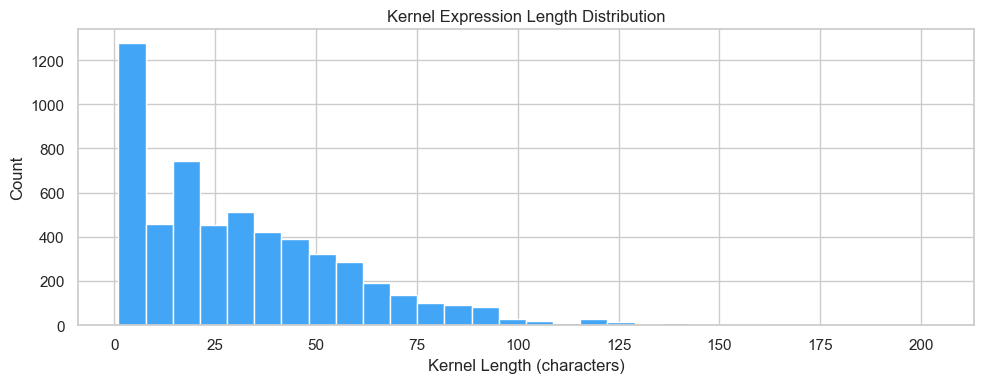

In [12]:
if len(df) > 0 and "kernel" in df.columns and df["kernel"].notna().any():
    display(Markdown("### 🔧 Kernel Analysis"))
    
    # Most common kernels
    display(Markdown("#### Top 10 Most Common Kernels"))
    kernel_counts = df["kernel"].value_counts().head(10).to_frame("Count")
    display(kernel_counts.style.bar(subset=["Count"], color="#90caf9"))
    
    # Kernel complexity (by length)
    df["kernel_length"] = df["kernel"].str.len()
    
    fig, ax = plt.subplots(figsize=(10, 4))
    df[df["kernel_length"] > 0]["kernel_length"].hist(bins=30, ax=ax, color="#42a5f5", edgecolor="white")
    ax.set_xlabel("Kernel Length (characters)")
    ax.set_ylabel("Count")
    ax.set_title("Kernel Expression Length Distribution")
    plt.tight_layout()
    plt.show()
elif len(df) > 0:
    display(Markdown("ℹ️ No kernel metadata available"))

## 8. Export Filtered Prompts

In [13]:
def filter_and_export(df, style=None, format_type=None, max_length=None, output_path=None):
    """Filter prompts and optionally export to JSONL."""
    filtered = df.copy()
    
    if style:
        filtered = filtered[filtered["style"] == style]
    if format_type:
        filtered = filtered[filtered["format_type"] == format_type]
    if max_length:
        filtered = filtered[filtered["prompt_length"] <= max_length]
    
    if output_path:
        export_cols = ["equation_id", "prompt", "style", "format_type", "ground_truth", "metadata"]
        export_df = filtered[[c for c in export_cols if c in filtered.columns]]
        
        with open(output_path, "w", encoding="utf-8") as f:
            for _, row in export_df.iterrows():
                f.write(json.dumps(row.to_dict(), ensure_ascii=False) + "\n")
        
        display(Markdown(f"✅ Exported {len(filtered):,} prompts to `{output_path}`"))
    
    return filtered

if len(df) > 0:
    display(Markdown("### 📤 Filter & Export Example"))
    display(Markdown("Filter chain-of-thought prompts under 2000 characters:"))

    sample_filter = filter_and_export(df, style="chain-of-thought", max_length=2000)
    display(Markdown(f"**Result:** {len(sample_filter):,} prompts match the filter"))

### 📤 Filter & Export Example

Filter chain-of-thought prompts under 2000 characters:

**Result:** 1,152 prompts match the filter

## 9. Summary Statistics

In [14]:
if len(df) > 0:
    display(Markdown("### 📈 Final Summary"))

    summary_data = {
        "Metric": [
            "Total Prompts",
            "Unique Equations", 
            "Prompt Styles",
            "Format Types",
            "With Ground Truth",
            "Avg Prompt Length",
            "Total Characters",
        ],
        "Value": [
            f"{len(df):,}",
            f"{df['equation_id'].nunique():,}",
            f"{df['style'].nunique()}",
            f"{df['format_type'].nunique()}",
            f"{df['has_ground_truth'].sum():,}",
            f"{df['prompt_length'].mean():,.0f} chars",
            f"{df['prompt_length'].sum():,}",
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    display(summary_df.style.hide(axis='index').set_properties(**{'text-align': 'left', 'padding': '8px'}))

display(Markdown("---\n✅ **Exploration complete!**"))

### 📈 Final Summary

Metric,Value
Total Prompts,"5,595"
Unique Equations,"1,154"
Prompt Styles,3
Format Types,3
With Ground Truth,"5,595"
Avg Prompt Length,843 chars
Total Characters,"4,717,585"


---
✅ **Exploration complete!**